In [3]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from simulation_configs import generateConfigurations
from simulation_modules import DisturbanceModule, ProcessModule, FaultModule, hazardrate
import inspect
import pprint
import pandas as pd
import time as real_time

In [4]:
# Repeatable results
np.random.seed(85)

In [5]:
# Generate configurations
t, d, u, p, x, f, y, r, m, econ = generateConfigurations()

In [6]:
# Fault parameters TODO: Better printing of config
pprint.pprint(f)

{'C': {'L': 1296000,
       'alpha': 1e-05,
       'drift': 0,
       'drift_rate': 5.787037037037037e-07,
       'fault_type': 'drift',
       'runtime': 0,
       'state': 'none'},
 'C0': {'fault_type': 'none', 'state': 'none'},
 'F': {'fault_type': 'none', 'state': 'none'},
 'F0': {'fault_type': 'none', 'state': 'none'},
 'FW': {'fault_type': 'none', 'state': 'none'},
 'L': {'fault_type': 'none', 'state': 'none'},
 'valveF': {'fault_type': 'none', 'state': 'none'},
 'valveF0': {'fault_type': 'none', 'state': 'none'},
 'valveFW': {'L': 1157760.0,
             'alpha': 1e-05,
             'fault_type': 'stuck',
             'runtime': 0,
             'state': 'none',
             'stuck': 0}}


In [7]:
# Fault module
print(inspect.getsource(FaultModule))

def FaultModule(p, x, f, t):
    # Run through all fault IDs
    for fault_id in f.keys():
        # Only consider faults with a fault type that is not none
        if not f[fault_id]['fault_type']=='none':
            # Increase component running time
            f[fault_id]['runtime'] += t['deltat']
            # Calculate current hazard rate
            h = hazardrate(f[fault_id]['runtime'], t['deltat'], f[fault_id]['alpha'], f[fault_id]['L'])
            # Trigger faults according to the probability for failure
            if np.random.uniform()<h and f[fault_id]['state']=='none':
                f[fault_id]['state'] = f[fault_id]['fault_type']
            # Adjust drift for currently drifting sensors
            if f[fault_id]['state']=='drift':
                f[fault_id]['drift'] += f[fault_id]['drift_rate']*t['deltat']
    
    return f



In [ ]:
# Failure CDF
print(inspect.getsource(failureCDF))

In [8]:
# Hazard rate
print(inspect.getsource(hazardrate))

def hazardrate(t_runtime, dt, alpha, L):
    # failure CDF
    # F = lambda t_runtime: 16*(1-alpha)*(t_runtime/L-0.5)**5 + alpha*(t_runtime/L-0.5) + 0.5
    F = lambda t_runtime: np.exp(alpha*(t_runtime-L))
    h = ( F(t_runtime+dt) - F(t_runtime) )/( (1 - F(t_runtime)) + 1e-8 )
    return h



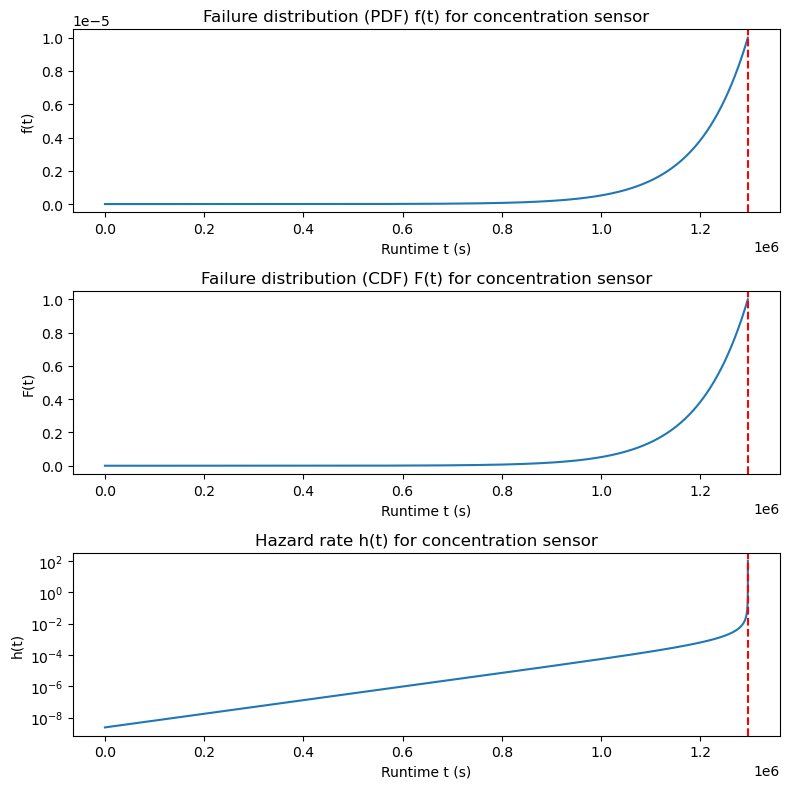

In [22]:
# Example of failure distribution and hazard rate
failureCDF = lambda t_runtime, alpha, L: np.exp(alpha*(t_runtime-L))
t_vector = np.arange(0, f['C']['L'], 1) # seconds
fig, ax = plt.subplots(3,1,figsize=(8,8))
ax[0].plot(t_vector, np.gradient(failureCDF(t_vector, f['C']['alpha'], f['C']['L']),t_vector[1]-t_vector[0]))
ax[0].axvline(x=f['C']['L'], color='r', linestyle='--')
ax[0].set_xlabel('Runtime t (s)')
ax[0].set_ylabel('f(t)')
ax[0].set_title('Failure distribution (PDF) f(t) for concentration sensor')
ax[1].plot(t_vector, failureCDF(t_vector,  f['C']['alpha'], f['C']['L']))
ax[1].axvline(x=f['C']['L'], color='r', linestyle='--')
ax[1].set_xlabel('Runtime t (s)')
ax[1].set_ylabel('F(t)')
ax[1].set_title('Failure distribution (CDF) F(t) for concentration sensor')
ax[2].semilogy(t_vector, hazardrate(t_vector, t['deltat'],  f['C']['alpha'], f['C']['L']))
ax[2].axvline(x=f['C']['L'], color='r', linestyle='--')
ax[2].set_xlabel('Runtime t (s)')
ax[2].set_ylabel('h(t)')
ax[2].set_title('Hazard rate h(t) for concentration sensor')
plt.tight_layout()
plt.show()

In [10]:
# Generate disturbances
d_range = DisturbanceModule(d,t)

In [11]:
# Simulation
# Start timer for simulation duration
start_time = real_time.time()
# List of variables to save
results_list = ['Time (days)', 'V', 'xWv', 'C', 'L', 'F0', 'FW', 'F', 'C0', 'Valve FW fault state']
# Preallocate numpy array to store results
results = np.full((t['N'], len(results_list)),np.nan)
# Start simulation
print('Simulation progress:')
while t['tvector'][t['i']] < t['tmax']: # necessary while loop, since shuts can skip forward in time
    # Update time (check for jumps from maintenance)
    t['tvector'][t['i']+1] = t['tvector'][t['i']] + t['deltat']
    # Current disturbance
    d_now = {col: d_range[col][t['i']] for col in ['F0', 'C0']}
    # Process module
    x = ProcessModule(p, u, d_now, x, f, t)
    # Fault module
    f = FaultModule(p, x, f, t)
    # Update results
    valveFW_state = 0 if f['valveFW']['state']=='none' else 1
    results[t['i'], :] = [t['tvector'][t['i']]/(3600*24),
                          x['V'], 
                          x['xWv'], 
                          x['C'], 
                          x['L'], 
                          x['F0'], 
                          x['FW'], 
                          x['F'], 
                          d_now['C0'],
                          valveFW_state]
    # Display progress in percent time
    if t['tvector'][t['i']] % (2*24*3600) == 0:
        print(f'{t["tvector"][t["i"]]/t["tmax"]*100:.2f}%')
    # Update time index
    t['i'] += 1

# End timer for simulation duration
end_time = real_time.time()
# Print simulation duration
print(f'Done! Simulation duration: {end_time-start_time:.1f} seconds.')

Simulation progress:
0.00%
7.14%
14.29%
21.43%
28.57%
35.71%
42.86%
50.00%
57.14%
64.29%
71.43%
78.57%
85.71%
92.86%
Done! Simulation duration: 1.4 seconds.


In [12]:
# Convert results (numpy array) to DataFrame
df = pd.DataFrame(results, columns=results_list)
df.set_index('Time (days)', inplace=True)

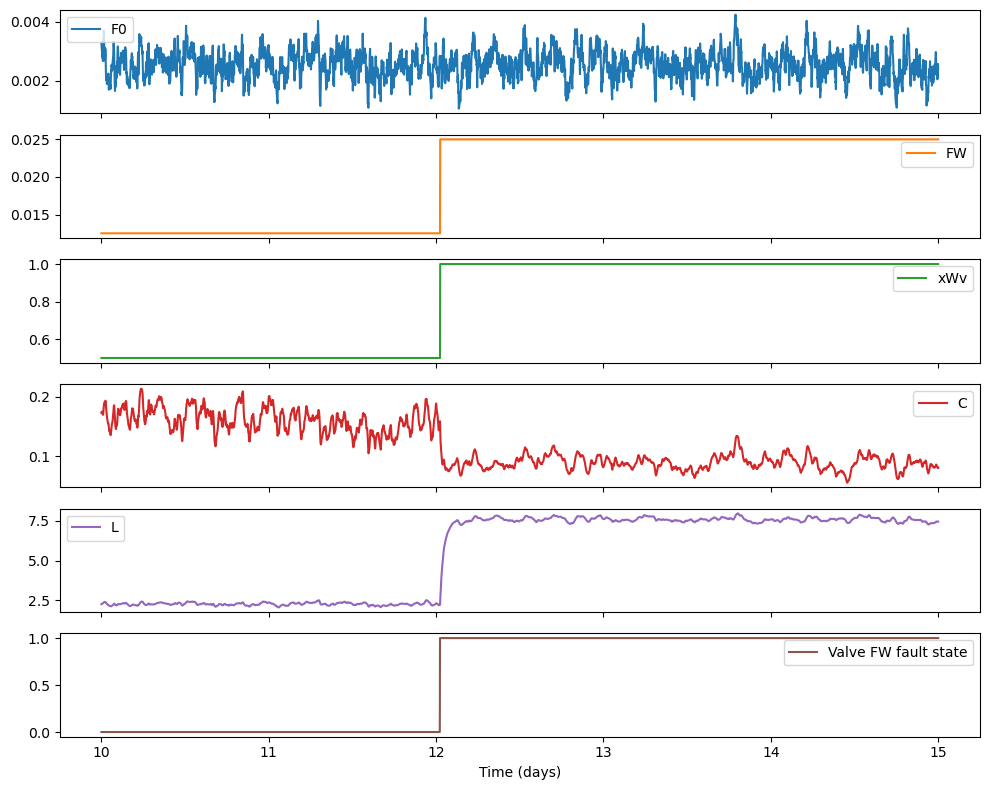

In [17]:
# Plot
startInd = 10
endInd = 15
plot_list = ['F0','FW','xWv','C','L','Valve FW fault state']
df[plot_list].loc[startInd:endInd].plot(subplots=True, figsize=(10,8))
plt.tight_layout()